# Marketing Case

The Marketing team has collected some data from previous marketing campaign. The data set includes customer information, described below, as a well as whether the customer responded to the marketing campaign or not.

## Data

 Here is the description of each column in the data set:
 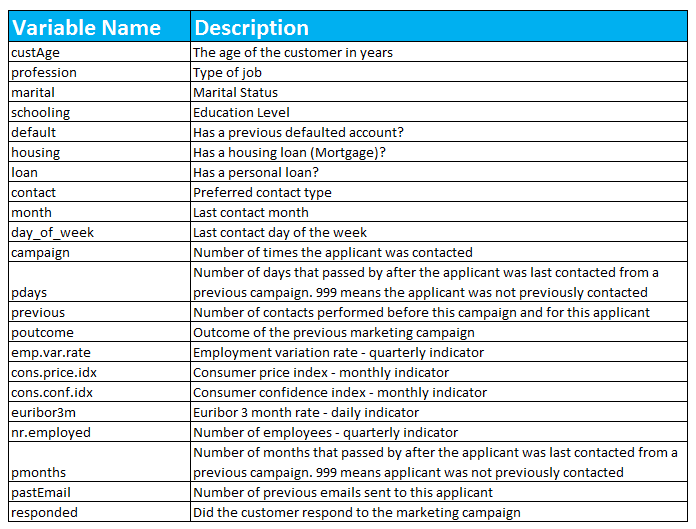
 

## Process

In order to develop the solution we will focus in the following steps

- Getting the Data
- Explore the Data
- Pre-process and clean the data
- Dimensionality reduction
- Build a model:
    - Apply appropiate sampling to split your population
    - Balance complexity and Performance (Variance / Bias)
    - Use sound cross validation techniques
    - Provide the performance measurements of the model
- Deploy the model

### Install required modules

In [1066]:
#!pip install pandas_profiling #https://github.com/pandas-profiling/pandas-profiling

## Getting the Data

In [2]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import pandas_profiling
from IPython.display import display
import seaborn as sns
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

from collections import Counter


In [105]:
#data and problem statment is from https://github.com/josuersd19/ELVT_CaseBInterview
file = 'marketing_training.csv'
#file = 'https://raw.githubusercontent.com/josuersd19/ELVT_CaseBInterview/master/marketing_training.csv'
data = pd.read_csv(file)

# Names & Number of rows and columns
print('Number or rows:', data.shape[0])
print('Number or columns:', data.shape[1])
#print('Columns Names:       Type')
#display(data.dtypes)

Number or rows: 7414
Number or columns: 22


In [4]:
#print 8 rows of the first 11 variables 
display(data[data.columns[:11]].head(4))
display(data[data.columns[:11]].tail(4))
#print 8 rows of the last 11 variables 
display(data[data.columns[11:]].head(4))
display(data[data.columns[11:]].tail(4))

,custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,campaign
0,55.0,admin.,single,university.degree,unknown,no,no,cellular,nov,mon,1
1,NaN,blue-collar,married,NaN,no,no,no,cellular,jul,mon,1
2,42.0,technician,married,high.school,no,no,no,telephone,may,mon,1
3,55.0,management,divorced,NaN,unknown,yes,yes,cellular,jul,wed,2


,custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,campaign
7410,45.0,blue-collar,married,basic.4y,unknown,no,no,telephone,jul,tue,3
7411,27.0,blue-collar,single,NaN,no,no,no,cellular,may,fri,2
7412,51.0,unemployed,divorced,high.school,unknown,yes,no,cellular,nov,thu,2
7413,38.0,blue-collar,married,high.school,no,yes,no,telephone,may,fri,1


,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,responded
0,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,999.0,0,no
1,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,999.0,0,no
2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,999.0,0,no
3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,999.0,0,no


,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,responded
7410,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,999.0,0,no
7411,999,1,failure,-1.8,92.893,-46.2,1.250,5099.1,999.0,3,no
7412,999,0,nonexistent,-0.1,93.200,-42.0,4.076,5195.8,999.0,0,no
7413,999,0,nonexistent,1.1,93.994,-36.4,4.864,5191.0,999.0,0,no


#### Utility functions

In [106]:
def plot_histogram(df, targetColumn, withValues = True):
    
    _vertical = False
    _bins = range(0, 10, 1)
    distinct = set(df)

    if withValues:
        print(df.name, sorted(distinct))

        
    if data.contact.dtype=='O' or len(distinct)<8:
        _bins=len(distinct)*2 
        
    sns.distplot(df.loc[targetColumn == 'no'], kde=False, color= 'r', label = 'No', bins=_bins)
    sns.distplot(df.loc[targetColumn == 'yes'], kde=False, color= 'b', label = 'Yes', bins=_bins)
    
    plt.legend()
    plt.show()

def get_outliers_bounds(df):
    Q1 = df.quantile(.25)
    Q3 = df.quantile(.75)
    
    IQR = Q3 - Q1
    
    return [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR] 


True

## Explore the data

Before we start, we will get a quick snapshot of the dataset with the help of <b>pandas_profiling</b> a module that gives much more information than pandas' describe(). 
It provides Quantile Statistics, Descriptive statistics, most frequent values, histograms, correlations and more.

In [107]:
# display(data.describe())
# data.isnull().sum()
#Quick snapshop
print('Computing profiling report')
pfr = pandas_profiling.ProfileReport(data, correlation_overrides =['pmonths'])
pfr.to_file('ProfileReport.html')
pfr

# re-adjusting size for plots (pandas_profiling changes it)
sns.set(rc={'figure.figsize':(15,4)})

Computing profiling report


Number of variables,22
Number of observations,7414
Total Missing (%),2.9%
Total size in memory,1.2 MiB
Average record size in memory,176.0 B
Numeric,9
Categorical,11
Boolean,0
Date,0
Text (Unique),0
Rejected,2


There is a lot of information in this report, so first, we will review it and then we will take actions from there.
Number of variables	22
Number of observations	7414

O = outliers, M = Missing, C = Categorical, D = Dirty, N = Normalize, T = Transform 

    campaign O C T
    cons.conf.idx & cons.price.idx N T
    contact C
    custAge O M has 1804 / 24.3% missing values
    day_of_week M C has 711 / 9.6% missing values 
    default C D
    emp.var.rate, euribor3m, nr.employed
    housing, loan, marital, Month
    pastEmail O has 6495 / 87.6% zeros
    pdays, pmonths 999? rest under 1 month
    poutcome 6350 and pdays has 7123?
    previous leave as is, has 6350 / 85.6% zeros
    profession C
    responded Target 88.7/11.3
    schooling C D change missing to unknown has 2155 / 29.1% missing values 

    euribor3m is highly correlated with emp.var.rate (ρ = 0.97095) and was Rejected
    nr.employed is highly correlated with euribor3m (ρ = 0.94255) and was Rejected
    pmonths is highly correlated with pdays (ρ = 0.99999) and was Rejected

    Dataset has 26 duplicate rows 

In [108]:
#Sorting to keep the same order as profiling 
data = data[sorted(data.columns)]
print(data.columns.values)

['campaign' 'cons.conf.idx' 'cons.price.idx' 'contact' 'custAge'
 'day_of_week' 'default' 'emp.var.rate' 'euribor3m' 'housing' 'loan'
 'marital' 'month' 'nr.employed' 'pastEmail' 'pdays' 'pmonths' 'poutcome'
 'previous' 'profession' 'responded' 'schooling']


### campaign

campaign [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 26, 27, 29, 30, 31, 33, 34, 35, 39, 40]


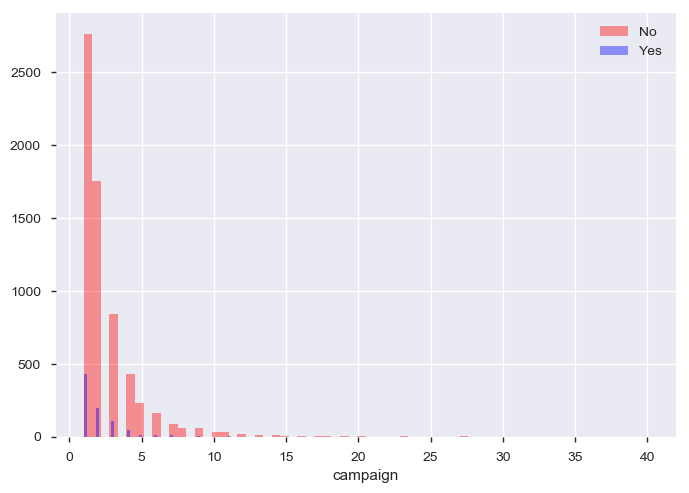

Outliers bounds: [-2.0, 6.0]
Rename all campaings higher than: 6.0 as 7+
campaign1 ['1', '2', '3', '4', '5', '6', '7+']


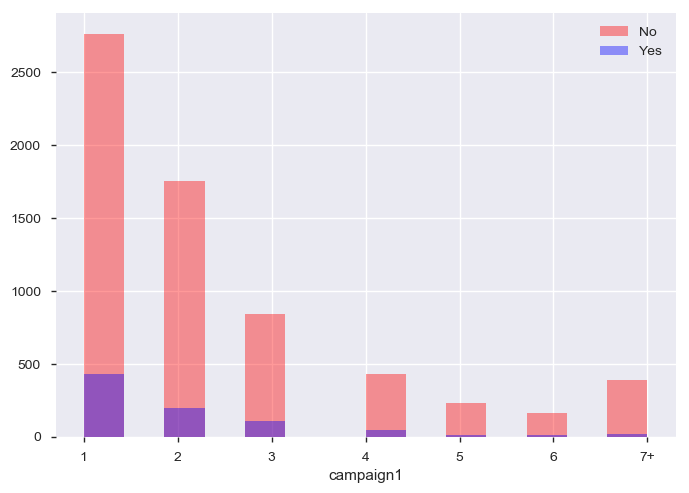

In [109]:
#campaign O C T

dataColumn = 'campaign'

plot_histogram(data[dataColumn], data.responded)

#outliers
outliers = get_outliers_bounds(data[dataColumn])
print('Outliers bounds:', outliers)

print('Rename all campaings higher than:',outliers[1], 'as 7+')
dataColumn = 'campaign1'
data[dataColumn] = data.campaign
data[dataColumn][data[dataColumn] > outliers[1]] = '7+'
data[dataColumn] = data[dataColumn].astype(str)

plot_histogram(data[dataColumn], data.responded)


### cons.price.idx  & cons.conf.idx

cons.conf.idx ['-50.80', '-50.00', '-49.50', '-47.10', '-46.20', '-45.90', '-42.70', '-42.00', '-41.80', '-40.80', '-40.40', '-40.30', '-40.00', '-39.80', '-38.30', '-37.50', '-36.40', '-36.10', '-34.80', '-34.60', '-33.60', '-33.00', '-31.40', '-30.10', '-29.80', '-26.90']
Outliers bounds: [-52.150000000000006, -26.949999999999992]


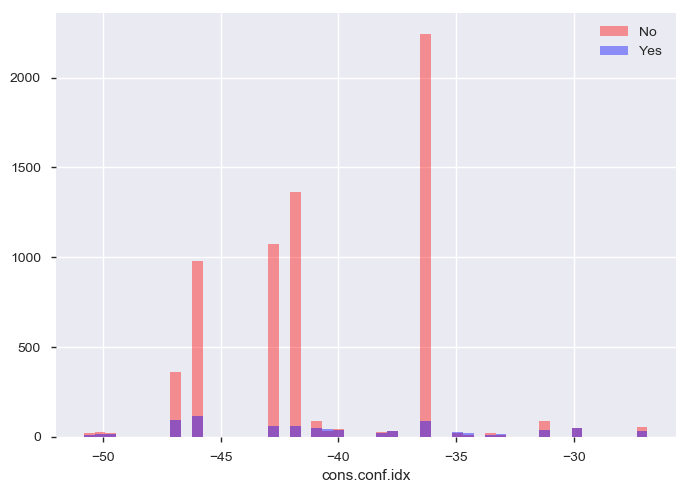

cons.price.idx ['92.20', '92.38', '92.43', '92.47', '92.65', '92.71', '92.76', '92.84', '92.89', '92.96', '93.08', '93.20', '93.37', '93.44', '93.75', '93.80', '93.88', '93.92', '93.99', '94.03', '94.06', '94.20', '94.22', '94.47', '94.60', '94.77']
Outliers bounds: [91.69650000000001, 95.3725]


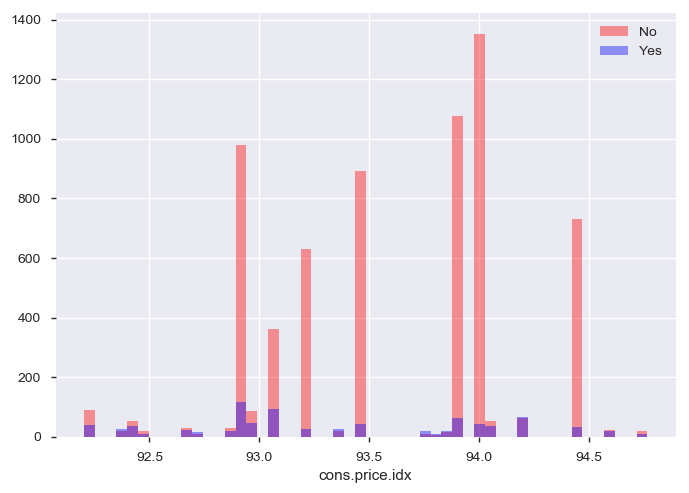

In [110]:
dataColumn = 'cons.conf.idx'
print(data[dataColumn].name,  ["%.2f"%item for item in sorted(set(data[dataColumn]))])

#outliers
outliers_bounds = get_outliers_bounds(data[dataColumn])
print('Outliers bounds:', outliers_bounds)

plot_histogram(data[dataColumn], data.responded, False)


dataColumn = 'cons.price.idx'
print(data[dataColumn].name,  ["%.2f"%item for item in sorted(set(data[dataColumn]))])

#outliers
outliers_bounds = get_outliers_bounds(data[dataColumn])
print('Outliers bounds:', outliers_bounds)

plot_histogram(data[dataColumn], data.responded, False)


### contact

contact ['cellular', 'telephone']


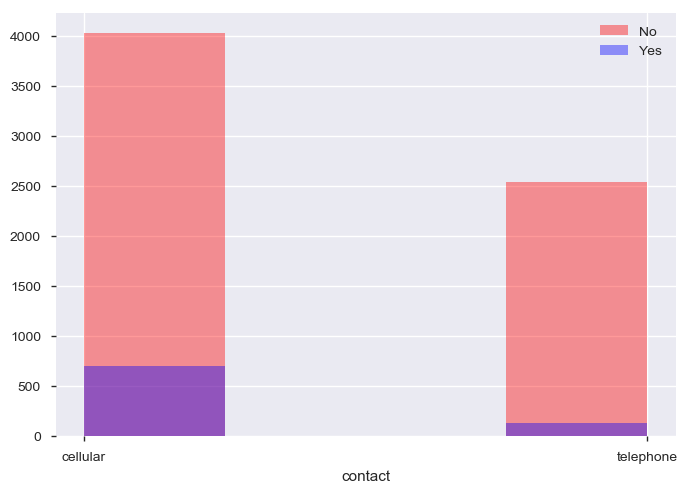

,count,unique,top,freq
contact,7414,2,cellular,4731


In [111]:
#contact C

dataColumn = 'contact'
plot_histogram(data[dataColumn], data.responded)

pd.DataFrame(data[dataColumn].describe()).T

### custAge

'Fill NaNs with mean by marital status'

custAge Mean: 40


marital,divorced,married,single,unknown
custAge,45.0,42.0,33.0,41.0


'Check outliers'

Outliers bounds: [15.0, 63.0]
Rename all ages higher than 63.0 as 64


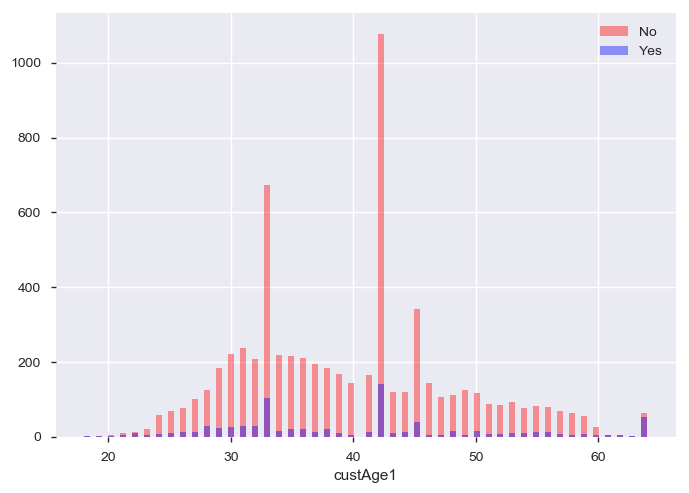

,count,mean,std,min,25%,50%,75%,max
custAge1,7414.0,39.790801,8.922048,18.0,33.0,40.0,45.0,64.0


In [112]:
#custAge O M has 1804 / 24.3% missing values
dataColumn = 'custAge'

display('Fill NaNs with mean by marital status')
#to input the age of the customers we will fill the missing information with the mean of marital status groups
data[dataColumn] = data.groupby(['marital']).transform(
    lambda x: x.fillna(round(x.mean())))[dataColumn]

print('custAge Mean:',round(data.custAge.mean()))
display(round(data[['custAge','profession','marital','schooling']].groupby('marital').mean()).T)

#outliers
display('Check outliers')
outliers_bounds = get_outliers_bounds(data[dataColumn])
print('Outliers bounds:', outliers_bounds)

print('Rename all ages higher than',outliers_bounds[1], 'as 64')

dataColumn = 'custAge1'

data[dataColumn] = data.custAge

data[dataColumn][data[dataColumn] > outliers_bounds[1]] = 64

plot_histogram(data[dataColumn], data.responded, False)
pd.DataFrame(data[dataColumn].describe()).T

### day_of_week

'Fill missing values with label "unknown"'

day_of_week ['fri', 'mon', 'thu', 'tue', 'unknown', 'wed']


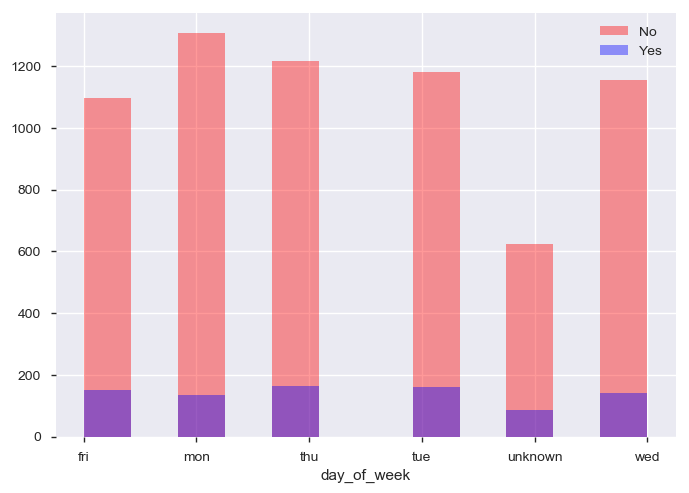

,count,unique,top,freq
day_of_week,7414,6,mon,1441


In [113]:
#day_of_week M C has 711 / 9.6% missing values 
dataColumn = 'day_of_week'

data[dataColumn]
display('Fill missing values with label "unknown"')
# sadly, we do not have more information about the missing values, could be weekends or any other week day
data[dataColumn].fillna('unknown', inplace=True)

plot_histogram(data[dataColumn], data.responded)

# plot_histogram(data[dataColumn], data.responded, False)
pd.DataFrame(data[dataColumn].describe()).T

### default

default ['no', 'unknown', 'yes']


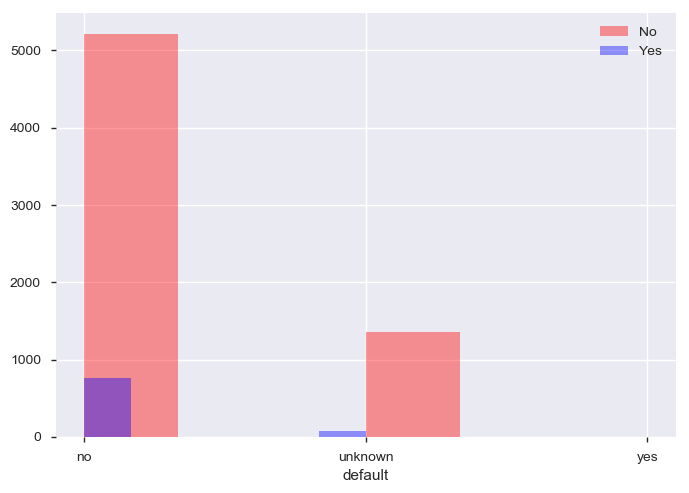

,count,unique,top,freq
default,7414,3,no,5981


"how many 'yes' rows do we have?"

,campaign,cons.conf.idx,cons.price.idx,contact,custAge,day_of_week,default,emp.var.rate,euribor3m,housing,...,pastEmail,pdays,pmonths,poutcome,previous,profession,responded,schooling,campaign1,custAge1
798,2,-42.0,93.2,cellular,31.0,tue,yes,-0.1,4.153,no,...,0,999,999.0,failure,1,unemployed,no,high.school,2,31.0


"yes" record dropped


0       unknown
1            no
2            no
3       unknown
4            no
5            no
6            no
7            no
8            no
9            no
10           no
11           no
12           no
13      unknown
14      unknown
15      unknown
16           no
17      unknown
18           no
19           no
20           no
21           no
22           no
23           no
24           no
25           no
26           no
27           no
28           no
29           no
         ...   
7384         no
7385    unknown
7386         no
7387         no
7388         no
7389         no
7390         no
7391    unknown
7392         no
7393         no
7394    unknown
7395         no
7396         no
7397         no
7398         no
7399         no
7400         no
7401         no
7402    unknown
7403         no
7404         no
7405    unknown
7406         no
7407         no
7408         no
7409         no
7410    unknown
7411         no
7412    unknown
7413         no
Name: default, Length: 7

default ['no', 'unknown']


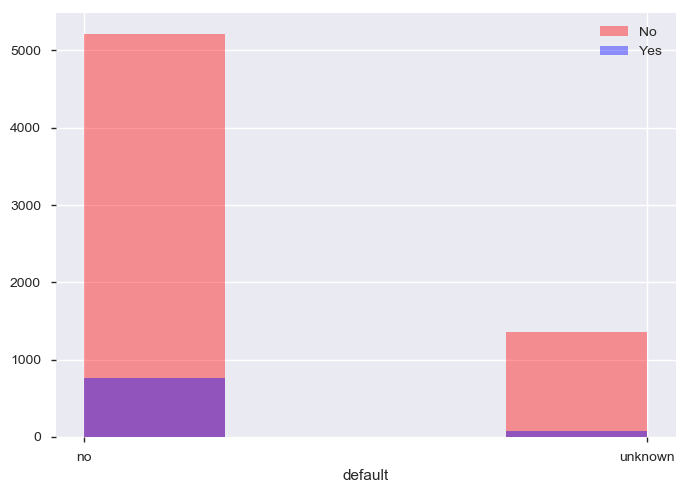

In [114]:
#default C D

dataColumn = 'default'
plot_histogram(data[dataColumn], data.responded)

display(pd.DataFrame(data[dataColumn].describe()).T)

display("how many 'yes' rows do we have?")
display(data[data[dataColumn] == 'yes'])
#there is only one record with yes, which we will drop
print('"yes" record dropped')
data = data[data[dataColumn] != 'yes']
display(data[dataColumn])
plot_histogram(data[dataColumn], data.responded)


### emp.var.rate, euribor3m, nr.employed

In [115]:
#euribor3m is highly correlated with emp.var.rate (ρ = 0.97095) and was Rejected
#nr.employed is highly correlated with euribor3m (ρ = 0.94255) and was Rejected
dataColumn = ["emp.var.rate", "euribor3m", 'nr.employed']

display(pd.DataFrame(data[dataColumn].describe()).T)

,count,mean,std,min,25%,50%,75%,max
emp.var.rate,7413.0,0.052111,1.568504,-3.400,-1.800,1.100,1.400,1.400
euribor3m,7413.0,3.583064,1.744970,0.634,1.334,4.857,4.961,5.045
nr.employed,7413.0,5165.220127,73.112738,4963.600,5099.100,5191.000,5228.100,5228.100


### housing, loan, marital, Month


housing ['no', 'unknown', 'yes']


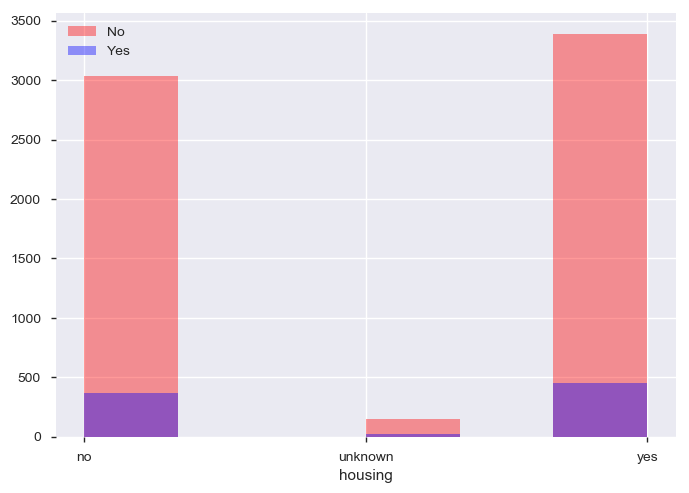

loan ['no', 'unknown', 'yes']


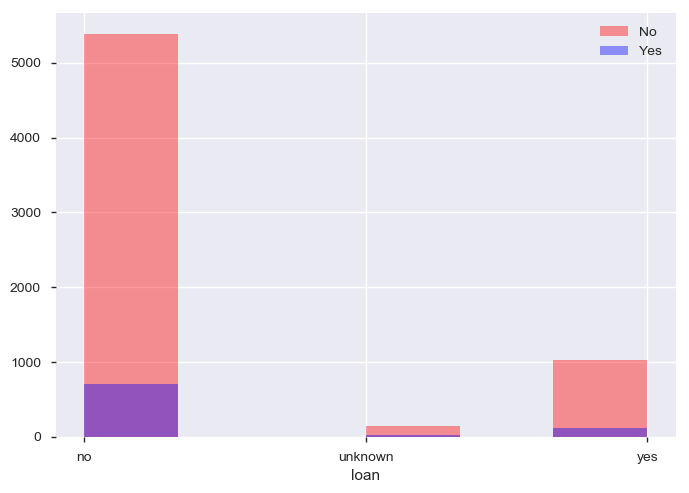

marital ['divorced', 'married', 'single', 'unknown']


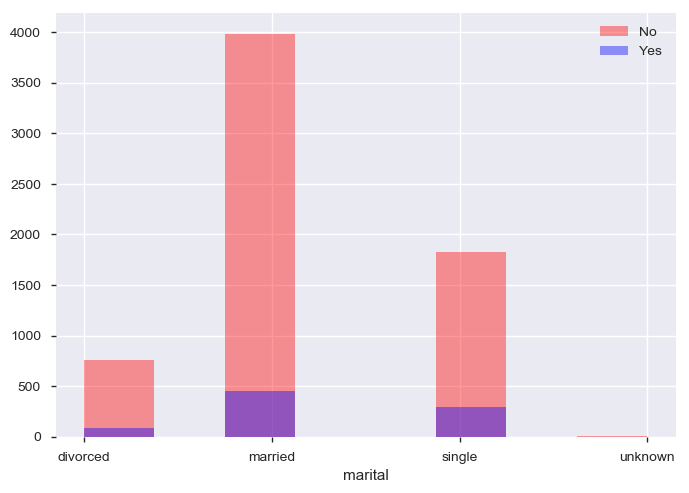

,count,unique,top,freq
housing,7413,3,yes,3840
loan,7413,3,no,6098
marital,7413,4,married,4444


In [116]:
#housing, loan, marital, Month

dataColumn = ["housing", "loan", "marital"]

for each in dataColumn:
    plot_histogram(data[each], data.responded)

display(pd.DataFrame(data[dataColumn].describe()).T)


### month

month ['apr', 'aug', 'dec', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep']


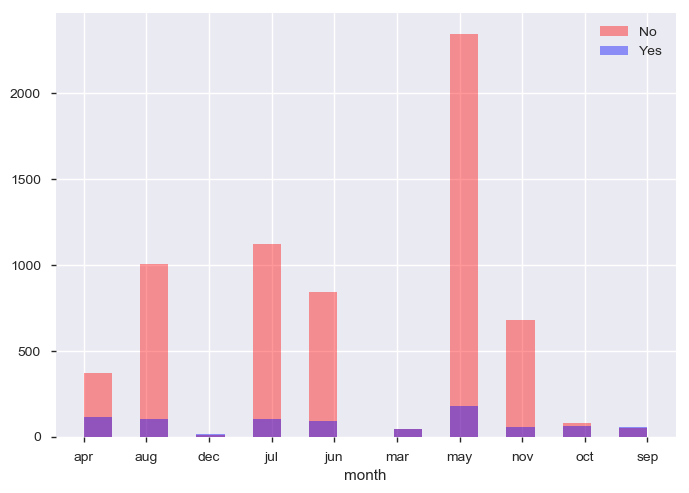

,count,unique,top,freq
month,7413,10,may,2529


In [117]:
# Month

dataColumn = "month"

plot_histogram(data[dataColumn], data.responded)

display(pd.DataFrame(data[dataColumn].describe()).T)


### pastEmail 

,count,mean,std,min,25%,50%,75%,max
pastEmail,7413.0,0.361932,1.261747,0.0,0.0,0.0,0.0,18.0


pastEmail [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 18]


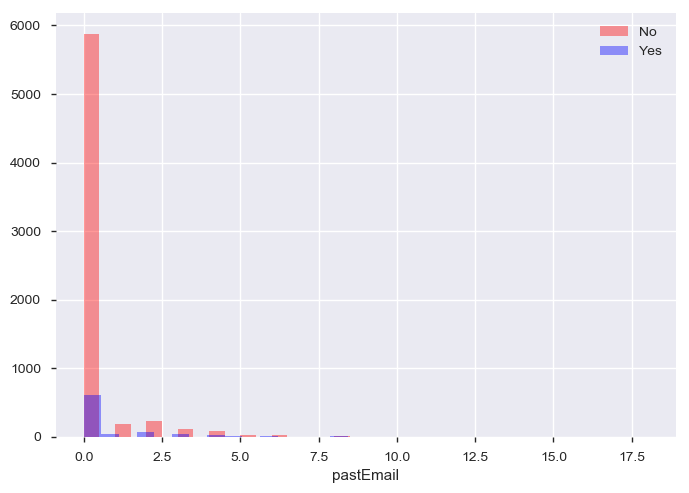

pastEmail [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 18]


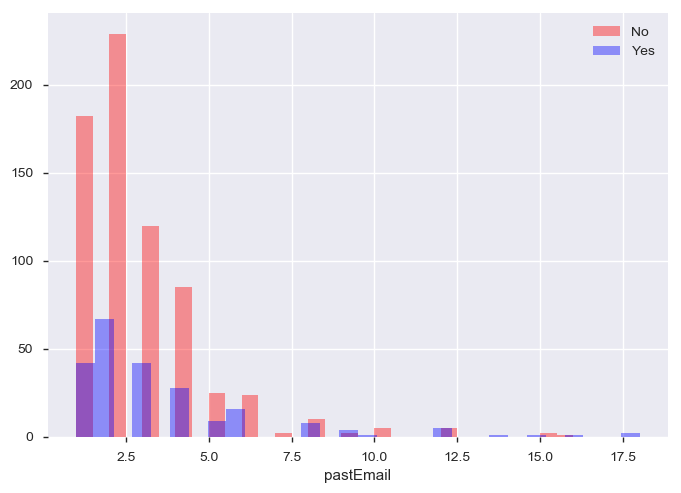

[-1.0, 7.0]

'Check outliers'

Outliers bounds: [0.0, 0.0]
Rename all ages higher than 0.0 as 1.0
pastEmail1 ['no', 'yes']


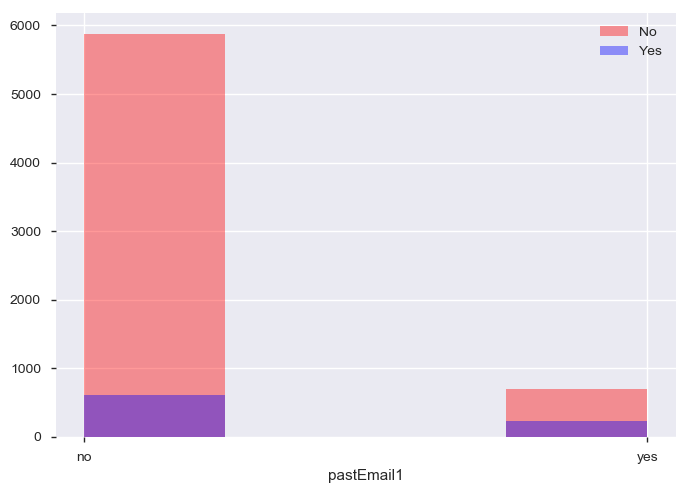

In [118]:
#pastEmail O has 6495 / 87.6% zeros
dataColumn = 'pastEmail'

display(pd.DataFrame(data[dataColumn].describe()).T)

plot_histogram(data[dataColumn], data.responded)

a = data[data[dataColumn]>0]
plot_histogram(a[dataColumn], a.responded)
display(get_outliers_bounds(a[dataColumn]))

#outliers
display('Check outliers')
outliers_bounds = get_outliers_bounds(data[dataColumn])
print('Outliers bounds:', outliers_bounds)

print('Rename all ages higher than',outliers_bounds[1], 'as', outliers_bounds[1]+1)

dataColumn = 'pastEmail1'

data[dataColumn] = data.pastEmail

data[dataColumn][data[dataColumn] > outliers_bounds[1]] = 'yes'
data[dataColumn][data[dataColumn] == 0] = 'no'

plot_histogram(data[dataColumn], data.responded)




### pdays, pmonths

,count,mean,std,min,25%,50%,75%,max
pdays,7380.0,959.844986,193.270611,0.0,999.0,999.0,999.0,999.0



yes, pdays and pmonths are very correlated with error: 2.2999999271799965e-07
pdays [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 999]


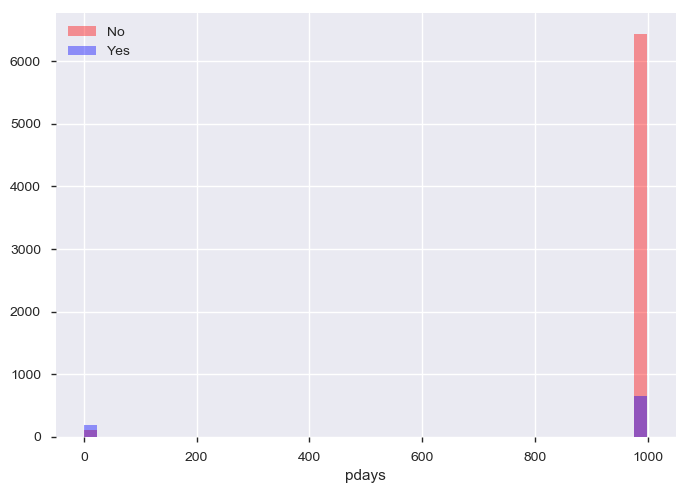

In [129]:
# pdays, pmonths 999? rest under 1 month
# pmonths is highly correlated with pdays (ρ = 0.99999) and was Rejected

dataColumn = 'pdays' 
display(pd.DataFrame(data[dataColumn].describe()).T)

#Are they really correlated?
days_months = data[data.pmonths<100][['pdays','pmonths']]

#small calculation to check errors by comparing both variables
print()
print('yes, pdays and pmonths are very correlated with error:', sum(days_months.pdays - days_months.pmonths*30))

plot_histogram(data[dataColumn], data.responded)

#too many 999s 96.1%!! rest under 1 month
data['pcontacted'] = data.pdays == 999   
#data.drop(['pdays','pmonths'], axis=1, inplace=True)
#print('pdays and pmonths have been dropped')


###  poutcome  and previous

,count,unique,top,freq
poutcome,7413,3,nonexistent,6350


poutcome ['failure', 'nonexistent', 'success']


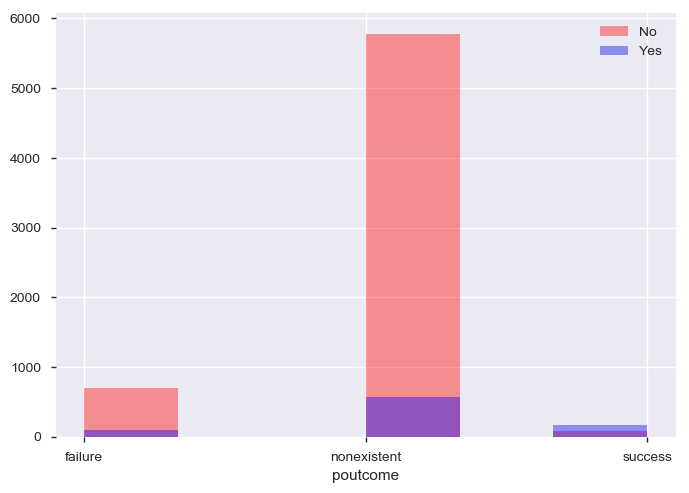

,count,mean,std,min,25%,50%,75%,max
previous,7413.0,0.184001,0.516723,0.0,0.0,0.0,0.0,6.0


previous [0, 1, 2, 3, 4, 5, 6]


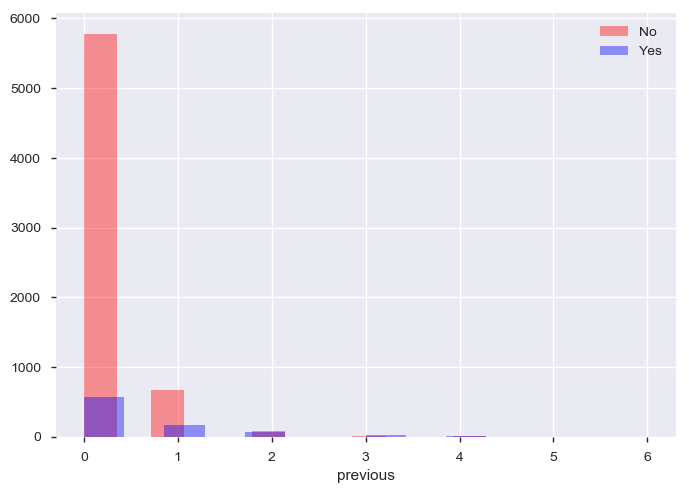

'Check outliers'

Outliers bounds: [0.0, 0.0]
Since there are many Zeros we will create another variable as previousContacted
Rename all previous higher than 0.0 as "yes" and 0 as "no"
previousContacted ['no', 'yes']


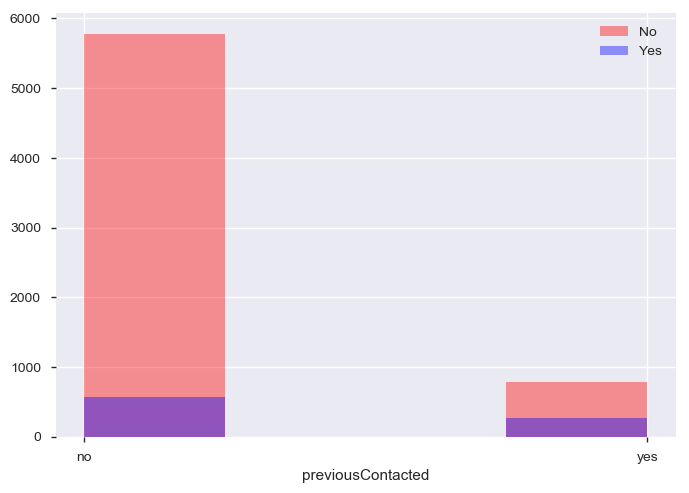

In [120]:
# poutcome 6350 and pdays has 999, 7123 times? 
# so, poutcome has 6350 nonexistent contacts, but there are 7123 that has never been contacted ?

# previous leave as is, has 6350 / 85.6% zeros
# ---as reminder--
# pdays: days that passed by after the applicant was last contacted, 
# previous: number of contacts 
# poutcome: outcome of the previous contact

dataColumn = ['poutcome', 'previous']

for column in dataColumn:
    display(pd.DataFrame(data[column].describe()).T)
    plot_histogram(data[column], data.responded)

#outliers
display('Check outliers')
outliers_bounds = get_outliers_bounds(data[dataColumn[1]])
print('Outliers bounds:', outliers_bounds)

dataColumn = 'previousContacted'

print('Since there are many Zeros we will create another variable as', dataColumn)
print('Rename all previous higher than',outliers_bounds[1], 'as "yes" and 0 as "no"')

data[dataColumn] = data.previous
data[dataColumn][data[dataColumn] > outliers_bounds[1]] = 'yes'
data[dataColumn][data[dataColumn] == 0] = 'no'

plot_histogram(data[dataColumn], data.responded)


### profession

,count,unique,top,freq,admin.,blue-collar,technician,management,services,unemployed,housemaid,unknown,self-employed,retired,student,entrepreneur
profession,7413,12,admin.,1885,1885,1665,1212,536,719,172,187,61,248,307,146,275


profession ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown']


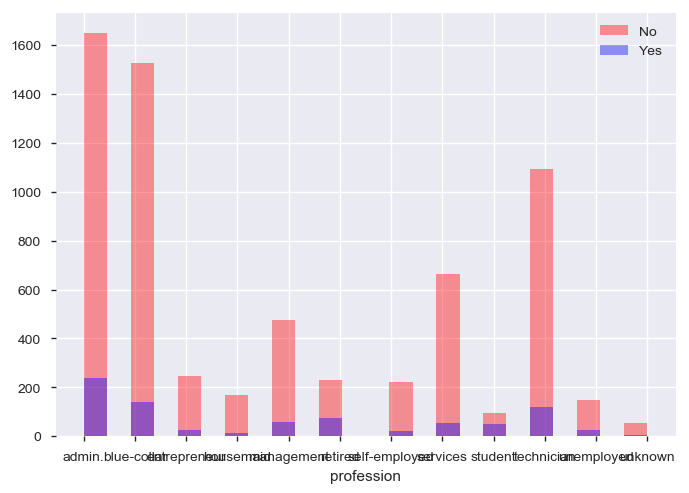

In [121]:
#profession C
dataColumn = 'profession'

#get counted values
counted = pd.DataFrame.from_dict(Counter(data[dataColumn]),orient='index')
counted.columns = [dataColumn]
display(pd.DataFrame(data[dataColumn].describe()).append(counted).T)

plot_histogram(data[dataColumn], data.responded)

### schooling

'Fill missing values with label "other"'

,count,unique,top,freq,university.degree,other,high.school,basic.4y,basic.9y,professional.course,basic.6y
schooling,7413,7,other,2387,1554,2387,1215,534,784,664,275


schooling ['basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'other', 'professional.course', 'university.degree']


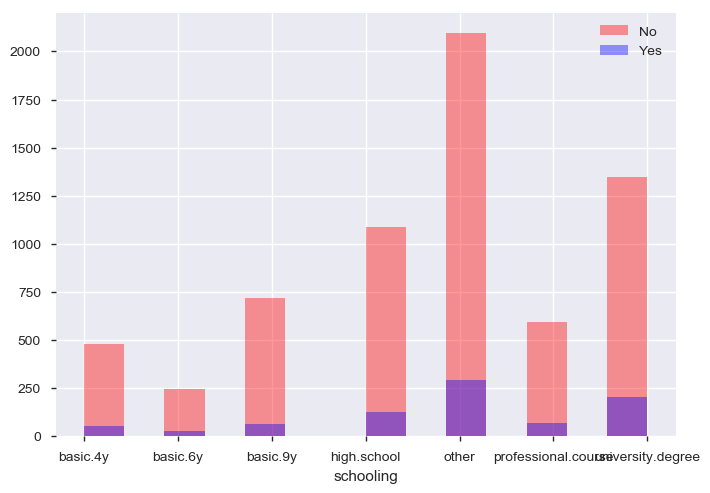

In [124]:
#schooling C D change missing to unknown has 2155 / 29.1% missing values 
dataColumn = 'schooling'


pd.DataFrame(data[dataColumn].describe()).T
display('Fill missing values with label "other"')
data[dataColumn].fillna('other', inplace=True)
data[dataColumn].replace('illiterate','other', inplace=True)
data[dataColumn].replace('unknown','other', inplace=True)


counted = pd.DataFrame.from_dict(Counter(data[dataColumn]),orient='index')
counted.columns = [dataColumn]
display(pd.DataFrame(data[dataColumn].describe()).append(counted).T)

plot_histogram(data[dataColumn], data.responded)


### duplicates

In [125]:
display(data.shape)
data.drop_duplicates(inplace=True)
display(data.shape)

data.columns

(7413, 26)

(7380, 26)

Index(['campaign', 'cons.conf.idx', 'cons.price.idx', 'contact', 'custAge',
       'day_of_week', 'default', 'emp.var.rate', 'euribor3m', 'housing',
       'loan', 'marital', 'month', 'nr.employed', 'pastEmail', 'pdays',
       'pmonths', 'poutcome', 'previous', 'profession', 'responded',
       'schooling', 'campaign1', 'custAge1', 'pastEmail1',
       'previousContacted'],
      dtype='object')

In [ ]:
data.marital

In [126]:
pandas_profiling.ProfileReport(data,correlation_overrides =['custAge1'])

Number of variables,27
Number of observations,7380
Total Missing (%),0.0%
Total size in memory,1.5 MiB
Average record size in memory,216.0 B
Numeric,10
Categorical,14
Boolean,0
Date,0
Text (Unique),0
Rejected,3


## Model with H2O

In [127]:
        
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
h2o.init(ip="localhost", port=54323)

Checking whether there is an H2O instance running at http://localhost:54323..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) Client VM (build 25.101-b13, mixed mode)


C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\server.py:331: UserWarning:   You have a 32-bit version of Java. H2O works best with 64-bit Java.
  Please download the latest 64-bit Java SE JDK from Oracle.

  warn("  You have a 32-bit version of Java. H2O works best with 64-bit Java.\n"


  Starting server from C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\gsaez\AppData\Local\Temp\tmp4z4zf6za
  JVM stdout: C:\Users\gsaez\AppData\Local\Temp\tmp4z4zf6za\h2o_gsaez_started_from_python.out
  JVM stderr: C:\Users\gsaez\AppData\Local\Temp\tmp4z4zf6za\h2o_gsaez_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.4
H2O cluster version age:,3 months and 28 days !!!
H2O cluster name:,H2O_from_python_gsaez_ujtgie
H2O cluster total nodes:,1
H2O cluster free memory:,247.5 Mb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [130]:
mrk = h2o.H2OFrame(data)
mrk.describe()

C:\ProgramData\Anaconda3\lib\site-packages\h2o\utils\shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Rows:7380
Cols:27




,campaign,cons.conf.idx,cons.price.idx,contact,custAge,day_of_week,default,emp.var.rate,euribor3m,housing,loan,marital,month,nr.employed,pastEmail,pdays,pmonths,poutcome,previous,profession,responded,schooling,campaign1,custAge1,pastEmail1,previousContacted,pcontacted
type,int,real,real,enum,int,enum,enum,real,real,enum,enum,enum,enum,real,int,int,real,enum,int,enum,enum,enum,int,int,enum,enum,enum
mins,1.0,-50.8,92.201,,18.0,,,-3.4,0.634,,,,,4963.6,0.0,0.0,0.0,,0.0,,,,1.0,18.0,,,
mean,2.5228997289972814,-40.56775067750686,93.57061829268248,,39.95975609756106,,,0.048265582655826506,3.5789429539295465,,,,,5165.0473712737175,0.3632791327913282,959.8449864498646,959.6164182475155,,0.1845528455284555,,,,2.0264026402640316,39.80514905149058,,,
maxs,40.0,-26.9,94.767,,94.0,,,1.4,5.045,,,,,5228.1,18.0,999.0,999.0,,6.0,,,,6.0,64.0,,,
sigma,2.6999553269557093,4.653732975650036,0.5791390659374276,,9.463398349914998,,,1.5697319890162231,1.7462251198691165,,,,,73.14368800240456,1.2641956447212033,193.2706108634015,194.39748115445147,,0.5173031258093425,,,,1.2618634459509646,8.93268712954785,,,
zeros,0,0,0,,0,,,0,0,,,,,0,6462,2,2,,6318,,,,0,0,,,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,411,0,0,0,0
0,1.0,-42.0,93.2,cellular,55.0,mon,unknown,-0.1,4.191,no,no,single,nov,5195.8,0.0,999.0,999.0,nonexistent,0.0,admin.,no,university.degree,1.0,55.0,no,no,True
1,1.0,-42.7,93.918,cellular,42.0,mon,no,1.4,4.96,no,no,married,jul,5228.1,0.0,999.0,999.0,nonexistent,0.0,blue-collar,no,other,1.0,42.0,no,no,True
2,1.0,-36.4,93.994,telephone,42.0,mon,no,1.1,4.857,no,no,married,may,5191.0,0.0,999.0,999.0,nonexistent,0.0,technician,no,high.school,1.0,42.0,no,no,True


In [131]:
categorical_variables = ['contact','day_of_week','default','housing',  'loan','marital', 'month','poutcome','previousContacted',
                        'profession', 'responded', 'schooling','pcontacted']
for variable in categorical_variables:
    mrk[variable] = mrk[variable].asfactor() 
    
predictors = mrk.columns
predictors.remove('responded')
response = 'responded'

In [132]:
train, valid = mrk.split_frame(ratios=[.8], seed=25)

In [133]:
bin_num = [8]#,16,32,2048]

for key, num in enumerate(bin_num):
    mrk_gbm = H2OGradientBoostingEstimator(nbins_cats = num, seed = 25)
    mrk_gbm.train(x = predictors, y= response, training_frame = train, validation_frame = valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [134]:
bin_num = [8]#,16,32,2048]
#with 999 as true
for key, num in enumerate(bin_num):
    mrk_gbm2 = H2OGradientBoostingEstimator(nbins_cats = num, seed = 25)
    mrk_gbm2.train(x = predictors, y= response, training_frame = train, validation_frame = valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [135]:
print(str(num), mrk_gbm.auc(train=True))
print(str(num), mrk_gbm.auc(valid=True))
#print(mrk_gbm.aic)
#print(mrk_gbm.confusion_matrix)
#print(mrk_gbm.coef)
pd.DataFrame(mrk_gbm.varimp(), columns=['Columns','','',''])

8 0.864379647912753
8 0.8140710602642603


,Columns,,,
0,nr.employed,368.049072,1.000000,0.339827
1,euribor3m,108.478592,0.294739,0.100161
2,day_of_week,85.028107,0.231024,0.078508
3,poutcome,68.269661,0.185491,0.063035
4,schooling,64.712143,0.175825,0.059750
5,cons.conf.idx,64.158310,0.174320,0.059239
6,pdays,62.978859,0.171115,0.058150
7,month,37.901535,0.102980,0.034995
8,custAge,30.167231,0.081965,0.027854
9,pastEmail,26.857311,0.072972,0.024798


In [520]:
print(str(num), mrk_gbm2.auc(train=True))
print(str(num), mrk_gbm2.auc(valid=True))
#print(mrk_gbm.aic)
#print(mrk_gbm.confusion_matrix)
#print(mrk_gbm.coef)
pd.DataFrame(mrk_gbm2.varimp(), columns=['Columns','','',''])

8 0.8724768991261843
8 0.8014989447429011


,Columns,,,
0,nr.employed,421.452454,1.000000,0.374026
1,euribor3m,108.525894,0.257504,0.096313
2,day_of_week,95.702103,0.227077,0.084933
3,poutcome,72.077469,0.171022,0.063966
4,cons.conf.idx,67.583313,0.160358,0.059978
5,schooling,66.718452,0.158306,0.059210
6,custAge,60.590519,0.143766,0.053772
7,pdays,48.129738,0.114200,0.042714
8,month,33.410618,0.079275,0.029651
9,cons.price.idx,23.293768,0.055270,0.020672


0.8726263015166226
0.8064490598618572


In [136]:
h2o.cluster().shutdown()

H2O session _sid_89dc closed.


Get creative with data engineering
Get creative with dimensionality reduction

Build a model:
  -  Apply appropiate sampling to split your population
  -  Balance complexity and Performance (Variance / Bias)
  -  Use sound cross validation techniques
  -  Provide the performance measurements of the model